Model of Housing Prices

Problem

Predict median housing value for districts in California


Problem classification

Considering multiple features, so multiple regression.
Univariate regression, since only trying to predict a single median value for each district.

Performance Measure

Root Mean Square Error

In [35]:
#Download the data

from pathlib import Path
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [11]:
def loadHousingData():
    #a tarball is an archive file (.tgz extension)
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok= True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [12]:
housing = loadHousingData()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()
#total bedrooms has 207 null values
#all attributes except ocean_proximity are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
#can use value_counts to find number of categorical instances
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
#get summary of numerical attributes. null values are ignored.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

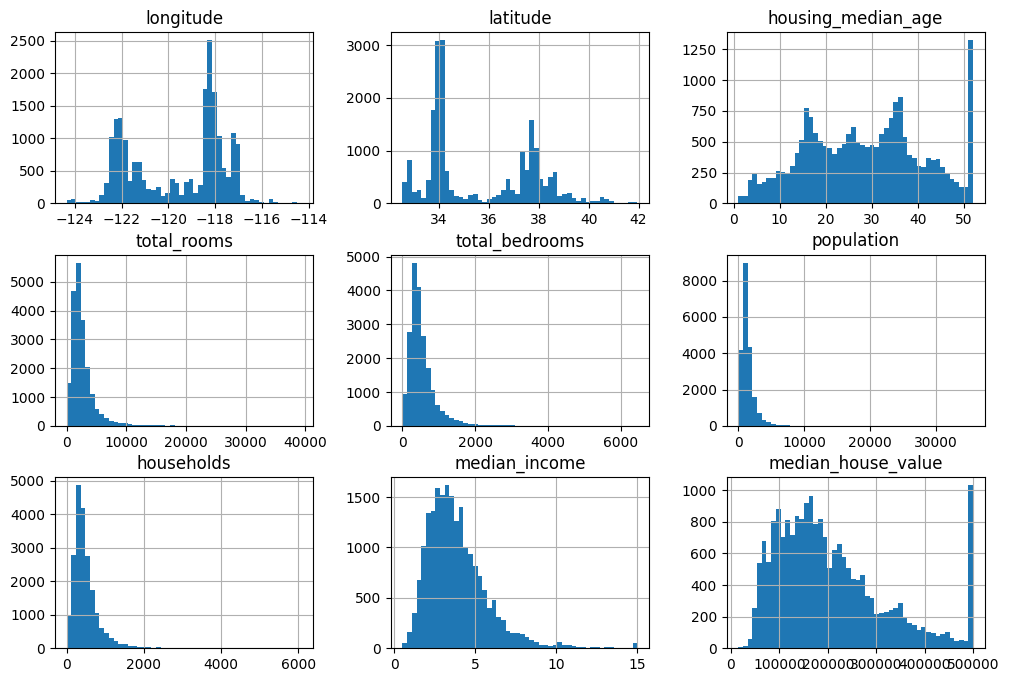

In [10]:
#histogram shows number of instances (on y-axis) with a given value range (on x-axis)

#hist method of matplotlib creates a histogram. Can do this for one feature at a time or on the whole dataset.

housing.hist(bins=50, figsize=(12,8))

Data analysis:

median income is not expressed in terms of currency but instead has been processed

housing median age and house value have been capped. Need to see if this is a problem - if need to predict values above 500k, then need to collect the proper labels for the capped districts, or remove those districts from the training set.

histograms are also skewed right. this can affect certain ML algos

In [13]:
#create the test set
def shuffleAndSplitData(data, test_ratio):
    shuffledIndices = np.random.permutation(len(data))
    testSetSize = test_ratio * len(data)
    testIndices = shuffledIndices[:testSetSize]
    trainIndices = shuffledIndices[testSetSize:]
    #use .iloc[] to obtain rows corresponding to relevant indices
    return data.iloc[trainIndices], data.iloc[testIndices]

Creating a Good Test Set


want to ensure getting the same test set on different runs. could set the seed but the solution breaks when you next fetch an updated dataset.

to ensure a stable train/test split even after updating the dataset, use each instance's identifier to decide whether or not it goes in the test set.

one way to do this is by computing a hash of each instance's identifier, and then putting that instance in the test set if the has is lower than or equal to 20% of the maximum hash value.

In [20]:
#crc32 generates a unique 32-bit checksum for a given set of data


def isIdInTestSet(identifier, testRatio):
    #check if id is in test set
    return crc32(np.int64(identifier)) < testRatio * 2 ** 32

def splitDataWithIdHash(data, testRatio, idColumn):
    #obtain train and test set ids
    ids = data[idColumn]
    inTestSet = ids.apply(lambda id_: isIdInTestSet(id_, testRatio))
    return data.loc[~inTestSet], data.loc[inTestSet]

In [23]:
#in this problem we do not have IDs. 
#might be able to use row index as ID but then you need to make sure new data gets appended to the end of the data set and no row ever gets deleted. 

#reset_index() adds an 'index' column
housingWithId = housing.reset_index()


In [22]:
#can also create a stable unique ID using the features in the dataset, e.g. specific combination of latitude and longitude
housingWithId["id"] = housing["longitude"]*1000 + housing['latitude']
housingWithId
trainSet, testSet = splitDataWithIdHash(housingWithId, 0.2, "id")

In [26]:
#can also do the same with sklearn
trainSet, testSet = train_test_split(housing, test_size=0.2, random_state= 42)

Want to get a representative sample? Instead of random sampling, use stratified sampling. Try to maintain population ratios (e.g. gender ratio) in the sample.
The population is divided into homogeneous subgroups called strata and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

In this problem we want to ensure that the test set is representative of the various categories of incomes in the whole dataset. The aim is to create an income category attribute based on the median income. Note that some median incomes go far beyond 6. You need a sufficient number of instances in the dataset for each stratum, or else the estimate of a stratum's importance may be biased. There should not be too many strata, and each stratum should be large enough.

In [28]:
#pd.cut is useful for when you need to sort data values into bins or ranges
#here we divide bins but groups of 1.5units of median income (roughly 15,000USD)
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0,1.5,3,4.5,6,np.inf],
                               labels=[1,2,3,4,5])

Text(0, 0.5, 'Number of districts')

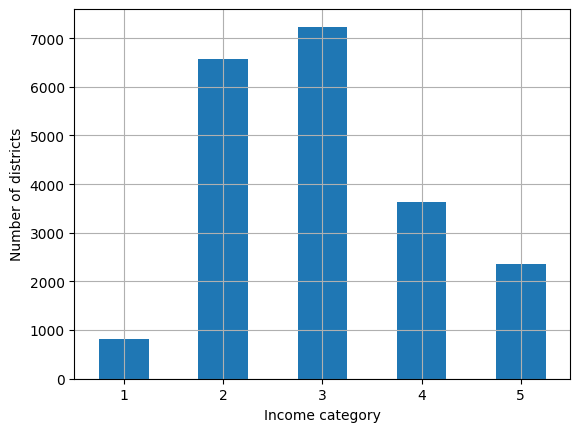

In [33]:
#.sort_index() sorts the indices from low to high
#.plot.bar() gives you a bar chart. rot = 0 causes vertical bars
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)

#add labels with plt.xlabel etc
plt.xlabel("Income category")
plt.ylabel("Number of districts")

In [36]:
#the stratified shuffle split class from sklearn.model_selection has split functions that can be used to generate n different stratified splits of the same dataset.
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state= 42)
stratSplits = []
for trainIndex, testIndex in splitter.split(housing, housing["income_cat"]):
    stratTrainSetN = housing.iloc[trainIndex]
    stratTestSetN = housing.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])

#one can also obtain just a single split using train_test_split:
stratTrainSet, stratTestSet = train_test_split(housing, test_size=0.2,
                                               stratify=housing["income_cat"], random_state=42)

In [ ]:
#won't use income category again, so now can drop it from each of the train and test sets
for set_ in (stratTrainSet, stratTestSet):
    set_.drop("income_cat", axis = 1, inplace = True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


Exploratory Data Analysis

In [51]:
#since we will experiment with various transformations of the full training set we can make a copy of the original to revert to afterwards if needed
housing = stratTrainSet.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

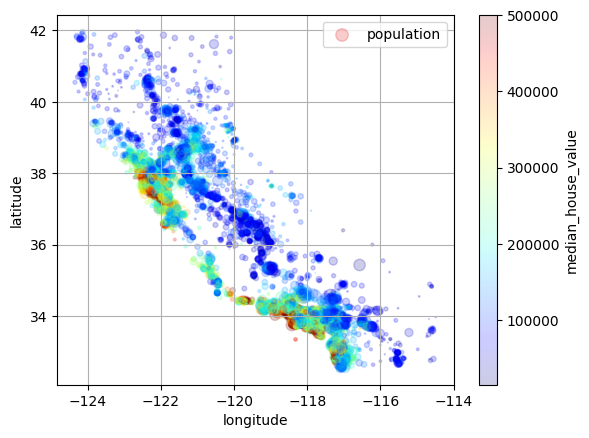

In [56]:
#specify kind="scatter" in the plot function to get a scatter graph
#you can also set the variables for the radius representation with the s parameter and colour representation with the c parameter. 
#the color map is given by the cmap parameter (gives a colour range, e.g. blue for low values and red for large values)

housing.plot(kind = "scatter", x="longitude", y="latitude", s=housing["population"]/100, c = "median_house_value", label = "population", cmap = "jet", colorbar=True, legend = True, sharex= False, grid = True, alpha = 0.2)